In [1]:
import sys
import os 
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
sys.path.append(os.path.join(os.getcwd(), ".."))
%cd ..
from generate import *
from utils.config import cfg_from_yaml_file
from joblib import Parallel, delayed
    

def remove_preexisting(sample_path):
    if os.path.exists(sample_path):
        [os.remove(os.path.join(sample_path, path)) for path in os.listdir(sample_path)]
    if not os.path.exists(sample_path):
        os.mkdir(sample_path)
    plt.show()

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
/srv/user/jschnei2/backup
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
config = cfg_from_yaml_file("custom/generator_config.yaml")
print(config)
forests = os.listdir("data/forest/original")
print(forests)

{'plot_path': 'data/forest/original/L1W.npy', 'occupancy_path': 'data/forest/occupancy/L1W.npy', 'voxelize': False, 'voxel_size': 0.1, 'remove_background': True, 'occupancy_resolution': 1, 'number_occupancy_points': 100000, 'fill_holes_how_far': 9, 'edge_length': 15, 'min_occupied': 0.8, 'sample_path': 'data/chunks/L1W.npy', 'save_config': True, 'normalize': True, 'save_labels': True, 'filter': True}
['A1N.npy', 'O1N.npy', 'LG3.npy', 'A1W.npy', 'G1W.npy', 'G1N.npy', 'forest_labeled_cleanest2.npy', 'G4N.npy', 'G2N.npy', 'G3W.npy', 'L2N.npy', 'LG1.npy', 'G2W.npy', 'G3N.npy', 'G4W.npy', 'L1N.npy', 'O1W.npy', 'LG2.npy', 'L1W.npy', 'L2W.npy']


In [3]:
#Voxelize all forests only once!!!
#def process(forest, config):
#  config.plot_path = os.path.join("data/forest/original", forest)
#  save_path = os.path.join("data/forest/voxelized10/", forest)
#  generator = SampleGenerator(config)
#  voxel_forest = np.hstack((generator.points, generator.label[:, np.newaxis]))
#  np.save(save_path, voxel_forest)
#  print("saved", forest)
#  return None

#results = Parallel(n_jobs=16, verbose=10)(delayed(process)(forest, config) for forest in forests)

In [4]:
N_SAMPLES = 100
VERBOSE = True
def process(forest, config):
    config.plot_path = forest
    config.sample_path = os.path.join("data/chunks/",forest.split("/")[-1])
    #remove_preexisting(config.sample_path)
    config.occupancy_path = os.path.join("data/forest/occupancy", forest.split("/")[-1])
    generator = SampleGenerator(config)
    generator.occupancy = generator.occupancy_grid()
    vertices, boolean, rotations, centers, vertices_unrotated = generator.random_generate(N_SAMPLES)
    if VERBOSE:
        plotfn(vertices, boolean, generator)
    samples, centers, rotations = generator.produce_samples_cuda(vertices[boolean], rotations[boolean], centers[boolean], vertices_unrotated[boolean])
    paths = generator.save_samples(samples, centers, rotations)
    print(len(paths), "saved for forest", forest)
    #return samples, centers, rotations
    return None

0
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
1
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
2
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
3
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
4
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
5
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
6
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
7
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
8
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy
9
100 saved for forest /user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy


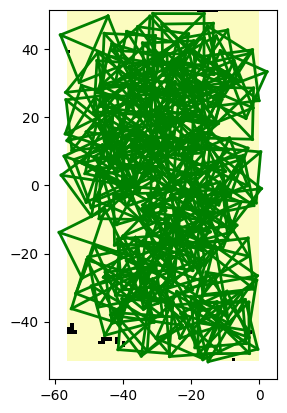

In [6]:
forest = "/user/jhenric/tree_learning_data/raw_data/val_data/L1W/final/jan_train05.npy"
for i in range(14):
    print(i)
    process(forest, config)

In [8]:
print(len(os.listdir("data/chunks/jan_train05.npy")))
print(len(os.listdir("data/chunks/15samplesjan_train05.npy")))

500
1500


In [ ]:
# for forest in forests:
#     sample_path = os.path.join("data/chunks", forest)
#     if len(os.listdir(sample_path)) < 500:
#         print("process ", forest)
#         process(forest,config)

In [27]:
def filter_cloud(source, target):
    points = np.load(source)
    #print(len(points))
    points, label = points[:, :3], points[:,3]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # filter out point
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=2,  std_ratio=1)
    pcd = pcd.select_by_index(ind)
    mask = np.zeros(len(points),dtype=bool)
    mask[ind] = True
    points = points[mask]
    label = label[mask]
    #print(len(points))
    cl, ind = pcd.remove_radius_outlier(nb_points=6, radius=0.2068)
    pcd = pcd.select_by_index(ind)
    mask = np.zeros(len(points),dtype=bool)
    mask[ind] = True
    points = points[mask]
    #print(len(points))
    points = np.hstack((points, label[mask][:, np.newaxis]))
    np.save(target, points)
    #print(target)
      

In [ ]:
for forest in forests:
    save_path = os.path.join("data/chunks", forest)
    source_path = os.path.join("data/chunks_notfiltered", forest)
    existing_trees = os.listdir(source_path)
    source_paths = [os.path.join(source_path, tree) for tree in existing_trees]
    save_paths = [os.path.join(save_path, tree) for tree in existing_trees]
    print(forest, len(save_paths))
    Parallel(n_jobs=16, verbose=1)(delayed(filter_cloud)(source, target) for source, target in zip(source_paths, save_paths))

In [24]:
for forest in forests:
    sample_path = os.path.join("data/chunks", forest)
    print(len(os.listdir(sample_path)))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [23]:
for forest in forests:
    sample_path = os.path.join("data/chunks", forest)
    existing_trees = os.listdir(sample_path)
    existing_trees = [tree if tree.split(".")[-1] == "txt" else None for tree in existing_trees]
    existing_trees = np.array(existing_trees)
    filtered = existing_trees[existing_trees != None]
    target_paths = [os.path.join(sample_path, tree) for tree in filtered]
    [os.remove(path) for path in target_paths]

In [18]:
existing_trees = np.array(existing_trees)
filtered = existing_trees[existing_trees != None]
filtered

array(['-c32.64-43.87-r0.68.npy', '-c-29.55-137.42-r0.47.npy',
       '-c-31.59-74.65-r5.9.npy', '-c44.44-68.2-r5.82.npy',
       '-c-23.28-147.0-r2.34.npy', '-c2.23-79.67-r5.2.npy',
       '-c-9.51-92.2-r3.24.npy', '-c-28.71-96.74-r0.44.npy',
       '-c15.97-64.58-r1.03.npy', '-c6.68-28.35-r1.47.npy',
       '-c-33.1-124.25-r0.74.npy', '-c-0.35-140.62-r2.02.npy',
       '-c-49.94-112.97-r2.87.npy', '-c7.02-125.77-r4.56.npy',
       '-c-54.55-109.31-r0.09.npy', '-c2.78-43.85-r3.5.npy',
       '-c14.04-92.59-r3.85.npy', '-c18.8-102.13-r2.41.npy',
       '-c35.98-78.29-r4.43.npy', '-c47.05-57.12-r0.92.npy',
       '-c-34.35-98.4-r4.12.npy', '-c-10.53-114.49-r2.22.npy',
       '-c0.98-9.11-r3.9.npy', '-c-5.83-125.84-r3.93.npy',
       '-c-11.7-48.29-r4.39.npy', '-c-20.06-3.24-r2.84.npy',
       '-c22.06-36.28-r2.91.npy', '-c11.24-12.23-r3.45.npy',
       '-c41.39-61.56-r4.25.npy', '-c12.66-14.49-r3.83.npy',
       '-c34.05-79.58-r6.18.npy', '-c-37.99-88.07-r2.88.npy',
       '-c10.22-54.5

4 saved for forest L2W.npy


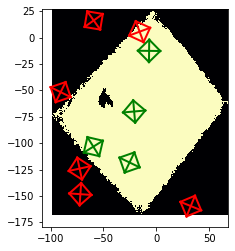

In [5]:
samples, centers, rotations = process(forests[-1], config)